In [1]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
import cx_Oracle
import matplotlib.pyplot as plt
import time 
import os
import pickle

os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\POS = EMI Scorecard Analysis")
seed = 5

# Read Data

In [4]:
df = pd.read_csv(os.getcwd()+r"\Data Files\export2.csv", encoding= 'unicode_escape')

# Define Key Variables

In [6]:
time_decision_date = 'TIME_CREATION_DATE'
target_variable = "RISK_FPD30"
risk_score = 'POS_AUG20_GM'

# Data Cleaning

In [7]:
df.head()

,SKP_CREDIT_CASE,TIME_CREATION_DATE,DECISION_OVERALL,POS_STATE,POS_CITY,CLIENT_EXI_3M,PRODUCT_GROUP,RISK_AGRF30,RISK_FPD30,RISK_AGRF10,RISK_FPD10,FLAG_1PCT_PHANTOM,SCORE_APSC_NOV18,POS_AUG20_GM
0,330883257,01-01-21,Approved,Madhya Pradesh,Shajapur,N,CD,1,0,1,0,0,0.010862,0.013562
1,330904438,01-01-21,Approved,Maharashtra,Pune,N,CD,1,0,1,0,0,0.006164,0.023314
2,330897810,01-01-21,Approved,Punjab,Ludhiana,N,CD,1,0,1,0,0,0.004586,0.021915
3,330900003,01-01-21,Approved,Karnataka,Bangalore,N,CD,1,0,1,0,0,0.007081,0.034587
4,330911354,01-01-21,Approved,Delhi,Delhi,N,CD,1,0,1,0,0,0.005619,0.014599


In [8]:
df[time_decision_date] = pd.to_datetime(df[time_decision_date],format = '%d-%m-%y')
df["MONTH_STR"] = df[time_decision_date].dt.strftime("%y-%m")

In [15]:
df.pivot_table(index=["POS_STATE","PRODUCT_GROUP"], columns=["MONTH_STR"], values = ["SKP_CREDIT_CASE"], aggfunc=["count"])

count                             \
                                   SKP_CREDIT_CASE                              
MONTH_STR                                    21-01    21-02    21-03    21-04   
POS_STATE            PRODUCT_GROUP                                              
Andhra Pradesh       CD                     2800.0   1973.0   2721.0   2287.0   
                     POS=EMI                   NaN      NaN      NaN    202.0   
Bihar                CD                     3715.0   4109.0   5011.0   4914.0   
Chandigarh           CD                      942.0    956.0    976.0    891.0   
Chhattisgarh         CD                     2420.0   2245.0   2375.0    646.0   
Dadra & Nagar Haveli CD                        NaN      NaN      NaN      NaN   
Delhi                CD                    16805.0  15642.0  17099.0  10656.0   
Gujarat              CD                     9587.0   8809.0  10438.0   8163.0   
Haryana              CD                     9766.0   9233.0  10393.0   9833.0   
Himachal Pradesh     CD                      141.0    228.0    362.0    446.0   
Jharkhand            CD                     4753.0   4748.0   5685.0   4568.0   
Karnataka            CD                     4161.0   3489.0   3997.0   3148.0   
Kerala               CD                     1939.0   1747.0   1986.0   2206.0   
Madhya Pradesh       CD                    13364.0  12134.0  14454.0   7050.0   
Maharashtra          CD                    21836.0  19549.0  22118.0  10301.0   
Orissa               CD                      856.0    741.0    871.0    854.0   
Pondicherry          CD                        NaN      NaN      NaN      1.0   
Punjab               CD                     7142.0   6420.0   7542.0   8449.0   
Rajasthan            CD                     9211.0   8507.0  10207.0   7169.0   
Tamil Nadu           CD                     4125.0   2690.0   3340.0   3431.0   
                     POS=EMI                   NaN      NaN      NaN    162.0   
Telangana            CD                     1146.0   1066.0   1363.0   1104.0   
                     POS=EMI                   NaN      NaN      NaN    203.0   
Uttar Pradesh        CD                    39219.0  36666.0  39958.0  31765.0   
                     POS=EMI                   NaN      NaN    448.0    544.0   
Uttaranchal          CD                     2509.0   2304.0   2403.0   1833.0   
West Bengal          CD                     4137.0   3962.0   4965.0   4525.0   

                                                            
                                                            
MONTH_STR                             21-05    21-06 21-07  
POS_STATE            PRODUCT_GROUP                          
Andhra Pradesh       CD               663.0    227.0   NaN  
                     POS=EMI          409.0    425.0   NaN  
Bihar                CD              2591.0   2683.0   NaN  
Chandigarh           CD               642.0    539.0   NaN  
Chhattisgarh         CD               872.0   1066.0   NaN  
Dadra & Nagar Haveli CD                 5.0      6.0   NaN  
Delhi                CD              2737.0   4959.0   NaN  
Gujarat              CD              5745.0   5824.0   NaN  
Haryana              CD              2626.0   3246.0   NaN  
Himachal Pradesh     CD                99.0    248.0   NaN  
Jharkhand            CD              2169.0   2641.0   NaN  
Karnataka            CD               156.0    107.0   NaN  
Kerala               CD               383.0   1127.0   NaN  
Madhya Pradesh       CD              2923.0   4862.0   NaN  
Maharashtra          CD              8063.0  11218.0   NaN  
Orissa               CD               139.0     69.0   NaN  
Pondicherry          CD                 NaN      NaN   NaN  
Punjab               CD              6830.0   4827.0   NaN  
Rajasthan            CD              2968.0   4400.0   NaN  
Tamil Nadu           CD               808.0     65.0   NaN  
                     POS=EMI          204.0     59.0   NaN  
Telangan

In [16]:
eligible_states = ["Andhra Pradesh","Tamil Nadu","Telangana","Uttar Pradesh"]

In [20]:
df = df[df["POS_STATE"].isin(eligible_states)]

df = df[df["RISK_AGRF30"]==1]

df_emi = df[df["PRODUCT_GROUP"]=="POS=EMI"]
df_cd = df[df["PRODUCT_GROUP"]=="CD"]


# Model Evaluation FPD30 for AUG20

### Gini Chart

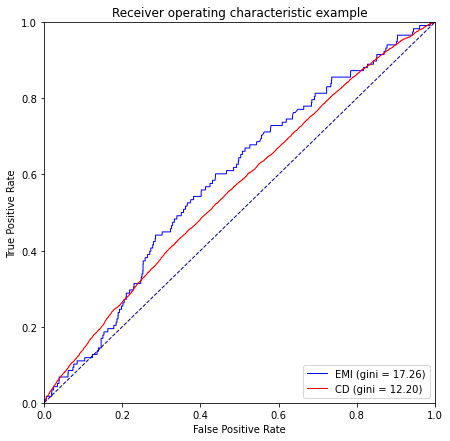

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1


fpr, tpr, thresholds = roc_curve(df_emi[target_variable],df_emi[risk_score])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label='EMI (gini = %0.2f)' % ((2*roc_auc-1)*100))


fpr, tpr, thresholds = roc_curve(df_cd[target_variable],df_cd[risk_score])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='CD (gini = %0.2f)' % ((2*roc_auc-1)*100))


ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [25]:
gini_dic = {}
for x in df_cd["MONTH_STR"].unique():
    try:
        if "MONTH_STR" not in gini_dic:
            gini_dic["MONTH_STR"] = []
        if "EMI" not in gini_dic: 
            gini_dic["EMI"] = []
        if "CD" not in gini_dic: 
            gini_dic["CD"] = []
        
        gini_dic["EMI"].append((2*roc_auc_score(df_emi[df_emi["MONTH_STR"]==x][target_variable],df_emi[df_emi["MONTH_STR"]==x][risk_score])-1)*100)
        gini_dic["CD"].append((2*roc_auc_score(df_cd[df_cd["MONTH_STR"]==x][target_variable],df_cd[df_cd["MONTH_STR"]==x][risk_score])-1)*100)
        gini_dic["MONTH_STR"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH_STR",inplace = True)
gini_df.reset_index(inplace = True)


ERROR
ERROR
ERROR


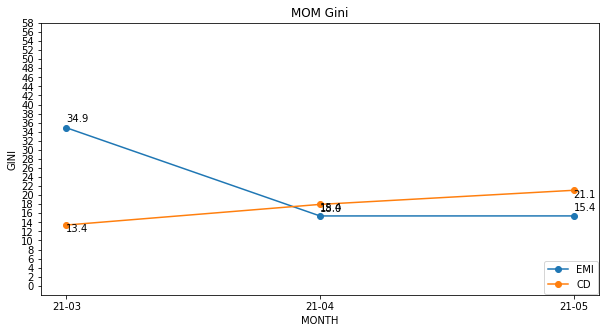

In [27]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH_STR"],gini_df["EMI"], marker='o', scaley = False, label = "EMI")
ax1.plot(gini_df["MONTH_STR"],gini_df["CD"], marker='o', scaley = False, label = "CD")
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["EMI"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df["EMI"][i]+1.2))
for i, txt in enumerate(gini_df["CD"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df["CD"][i]-1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(-2,45)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,60,2))
ax1.set_title("MOM Gini")
plt.show()


## Lifts and Gains Chart

In [28]:
def jitter(a_series, noise_reduction=1000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

In [29]:
def lift_and_gain_df(data=None,target=None, prob=None, bucket = 10):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob]+jitter(data[prob]), bucket)
    grouped = data.groupby('bucket', as_index = False)
    liftstable = pd.DataFrame()
    liftstable['min_prob'] = grouped[[prob,"bucket"]].agg(['min'])[prob].iloc[:,0]
    liftstable['max_prob'] = grouped[[prob,"bucket"]].agg(['max'])[prob].iloc[:,0]
    liftstable['total']   = grouped[[target,"bucket"]].agg(['count'])[target].iloc[:,0]
    liftstable['bads']   = round(grouped[[target,"bucket"]].agg(['sum'])[target].iloc[:,0])
    liftstable['goods'] = round(grouped[['target0',"bucket"]].agg(['sum'])['target0'].iloc[:,0])
    liftstable['%base'] = (liftstable.total / data[target].count())
    liftstable = liftstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    liftstable['cum%_base'] = (liftstable.total / data[target].count()).cumsum()
    liftstable['%bads'] = (liftstable['bads'] / data[target].sum())
    liftstable['%goods'] = (liftstable['goods'] / data['target0'].sum())
    liftstable['cum%_bads']=(liftstable['bads'] / data[target].sum()).cumsum()
    liftstable['cum%_goods']=(liftstable['bads'] / data['target0'].sum()).cumsum()

    
    liftstable['lift'] = np.round(liftstable['%bads']/liftstable['%base'] , 3)
    liftstable['cum_lift'] = np.round(liftstable['cum%_bads']/liftstable['cum%_base'] , 3)

    #Formating
    liftstable['%base']= liftstable['%base'].apply('{0:.2%}'.format)
    liftstable['%bads']= liftstable['%bads'].apply('{0:.2%}'.format)
    liftstable['%goods']= liftstable['%goods'].apply('{0:.2%}'.format)
    liftstable['cum%_bads']= liftstable['cum%_bads'].apply('{0:.2%}'.format)
    liftstable['cum%_goods']= liftstable['cum%_goods'].apply('{0:.2%}'.format)
    liftstable['cum%_base'] = liftstable['cum%_base'].apply('{0:.2%}'.format)

    liftstable.index = range(1,11)
    liftstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 13)
    return(liftstable)

In [30]:
#cum%_bads is gain_score
emi_lift = lift_and_gain_df(data=df_emi,target=target_variable, prob=risk_score)
cd_lift = lift_and_gain_df(data=df_cd,target=target_variable, prob=risk_score)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A val

In [33]:
emi_lift

,min_prob,max_prob,total,bads,goods,%base,cum%_base,%bads,%goods,cum%_bads,cum%_goods,lift,cum_lift
Decile,,,,,,,,,,,,,
1,0.023851,0.086162,234,13,221,10.02%,10.02%,11.02%,9.97%,11.02%,0.59%,1.099,1.099
2,0.018328,0.023838,233,16,217,9.98%,20.00%,13.56%,9.79%,24.58%,1.31%,1.359,1.229
3,0.015135,0.018326,234,23,211,10.02%,30.02%,19.49%,9.52%,44.07%,2.35%,1.945,1.468
4,0.013011,0.015111,233,12,221,9.98%,40.00%,10.17%,9.97%,54.24%,2.89%,1.019,1.356
5,0.011471,0.013011,233,10,223,9.98%,49.98%,8.47%,10.06%,62.71%,3.34%,0.849,1.255
6,0.010230,0.011469,234,12,222,10.02%,60.00%,10.17%,10.01%,72.88%,3.88%,1.015,1.215
7,0.008780,0.010230,233,10,223,9.98%,69.98%,8.47%,10.06%,81.36%,4.33%,0.849,1.163
8,0.006845,0.008776,234,7,227,10.02%,80.00%,5.93%,10.24%,87.29%,4.65%,0.592,1.091
9,0.005175,0.006840,233,8,225,9.98%,89.98%,6.78%,10.15%,94.07%,5.01%,0.679,1.045


In [34]:
cd_lift

,min_prob,max_prob,total,bads,goods,%base,cum%_base,%bads,%goods,cum%_bads,cum%_goods,lift,cum_lift
Decile,,,,,,,,,,,,,
1,0.033022,0.353389,18681,768,17913,10.00%,10.00%,13.88%,9.88%,13.88%,0.42%,1.387,1.387
2,0.026269,0.033021,18680,685,17995,10.00%,20.00%,12.38%,9.93%,26.25%,0.80%,1.238,1.313
3,0.022320,0.026269,18681,635,18046,10.00%,30.00%,11.47%,9.96%,37.72%,1.15%,1.147,1.257
4,0.019373,0.022320,18680,565,18115,10.00%,40.00%,10.21%,9.99%,47.93%,1.46%,1.021,1.198
5,0.017008,0.019373,18680,550,18130,10.00%,50.00%,9.94%,10.00%,57.87%,1.77%,0.994,1.157
6,0.014757,0.017007,18681,503,18178,10.00%,60.00%,9.09%,10.03%,66.96%,2.04%,0.909,1.116
7,0.012527,0.014757,18680,539,18141,10.00%,70.00%,9.74%,10.01%,76.69%,2.34%,0.974,1.096
8,0.010135,0.012527,18681,521,18160,10.00%,80.00%,9.41%,10.02%,86.11%,2.63%,0.941,1.076
9,0.007156,0.010135,18680,437,18243,10.00%,90.00%,7.90%,10.06%,94.00%,2.87%,0.790,1.044


### Cumulative Lift Chart 

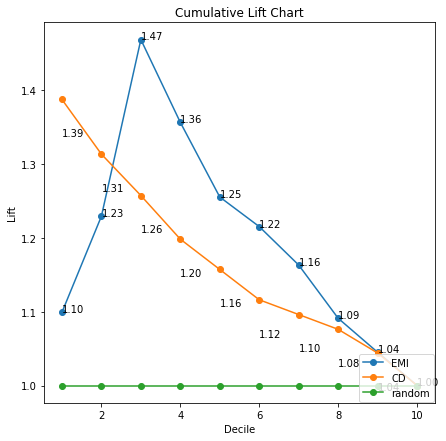

In [37]:
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(1,1,1)



ax1.plot(emi_lift.index,emi_lift["cum_lift"], label = "EMI", marker='o')
for i, txt in enumerate(emi_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (emi_lift.index[i], emi_lift["cum_lift"][i+1]))
    
ax1.plot(cd_lift.index,cd_lift["cum_lift"], label = "CD", marker='o')
for i, txt in enumerate(cd_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (cd_lift.index[i], cd_lift["cum_lift"][i+1]-0.05))



ax1.plot(np.arange(1,11,1),[1,1,1,1,1,1,1,1,1,1], label = 'random', marker='o')

plt.legend(loc='lower right', borderaxespad=0.1)
plt.xlabel("Decile")
plt.ylabel("Lift")

ax1.set_title("Cumulative Lift Chart")
plt.show()    


### Statewise GINI

In [40]:
gini_dic = {}
for x in df_cd["POS_STATE"].unique():
    try:
        if "POS_STATE" not in gini_dic:
            gini_dic["POS_STATE"] = []
        if "EMI" not in gini_dic: 
            gini_dic["EMI"] = []
        if "CD" not in gini_dic: 
            gini_dic["CD"] = []
        
        gini_dic["EMI"].append((2*roc_auc_score(df_emi[df_emi["POS_STATE"]==x][target_variable],df_emi[df_emi["POS_STATE"]==x][risk_score])-1)*100)
        gini_dic["CD"].append((2*roc_auc_score(df_cd[df_cd["POS_STATE"]==x][target_variable],df_cd[df_cd["POS_STATE"]==x][risk_score])-1)*100)
        gini_dic["POS_STATE"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "POS_STATE",inplace = True)
gini_df.reset_index(inplace = True)


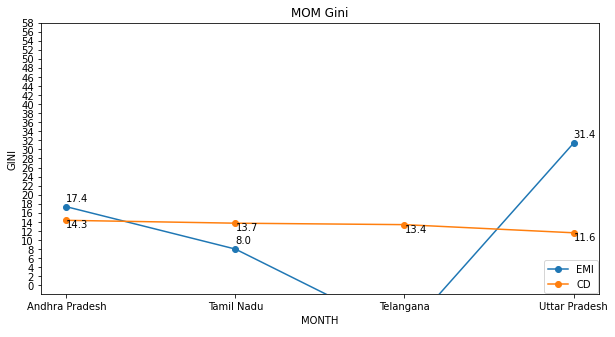

In [42]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["POS_STATE"],gini_df["EMI"], marker='o', scaley = False, label = "EMI")
ax1.plot(gini_df["POS_STATE"],gini_df["CD"], marker='o', scaley = False, label = "CD")
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["EMI"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["POS_STATE"][i], gini_df["EMI"][i]+1.2))
for i, txt in enumerate(gini_df["CD"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["POS_STATE"][i], gini_df["CD"][i]-1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(-2,45)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,60,2))
ax1.set_title("MOM Gini")
plt.show()


# Model Evaluation FPD30 for APSC

### Gini Chart

In [46]:
risk_score = 'SCORE_APSC_NOV18'

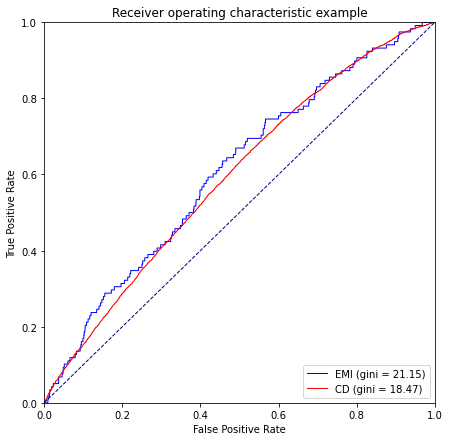

In [47]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1


fpr, tpr, thresholds = roc_curve(df_emi[target_variable],df_emi[risk_score])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label='EMI (gini = %0.2f)' % ((2*roc_auc-1)*100))


fpr, tpr, thresholds = roc_curve(df_cd[target_variable],df_cd[risk_score])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='CD (gini = %0.2f)' % ((2*roc_auc-1)*100))


ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [48]:
gini_dic = {}
for x in df_cd["MONTH_STR"].unique():
    try:
        if "MONTH_STR" not in gini_dic:
            gini_dic["MONTH_STR"] = []
        if "EMI" not in gini_dic: 
            gini_dic["EMI"] = []
        if "CD" not in gini_dic: 
            gini_dic["CD"] = []
        
        gini_dic["EMI"].append((2*roc_auc_score(df_emi[df_emi["MONTH_STR"]==x][target_variable],df_emi[df_emi["MONTH_STR"]==x][risk_score])-1)*100)
        gini_dic["CD"].append((2*roc_auc_score(df_cd[df_cd["MONTH_STR"]==x][target_variable],df_cd[df_cd["MONTH_STR"]==x][risk_score])-1)*100)
        gini_dic["MONTH_STR"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH_STR",inplace = True)
gini_df.reset_index(inplace = True)


ERROR
ERROR
ERROR


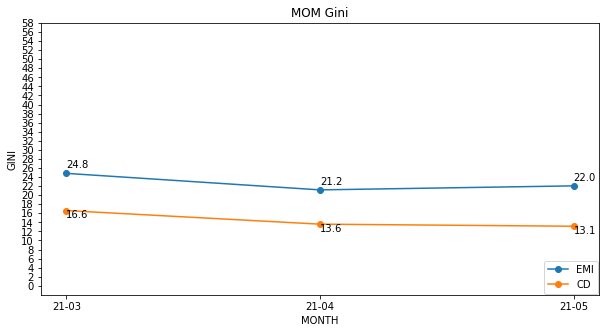

In [49]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH_STR"],gini_df["EMI"], marker='o', scaley = False, label = "EMI")
ax1.plot(gini_df["MONTH_STR"],gini_df["CD"], marker='o', scaley = False, label = "CD")
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["EMI"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df["EMI"][i]+1.2))
for i, txt in enumerate(gini_df["CD"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df["CD"][i]-1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(-2,45)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,60,2))
ax1.set_title("MOM Gini")
plt.show()


## Lifts and Gains Chart

In [50]:
def jitter(a_series, noise_reduction=1000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

In [51]:
def lift_and_gain_df(data=None,target=None, prob=None, bucket = 10):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob]+jitter(data[prob]), bucket)
    grouped = data.groupby('bucket', as_index = False)
    liftstable = pd.DataFrame()
    liftstable['min_prob'] = grouped[[prob,"bucket"]].agg(['min'])[prob].iloc[:,0]
    liftstable['max_prob'] = grouped[[prob,"bucket"]].agg(['max'])[prob].iloc[:,0]
    liftstable['total']   = grouped[[target,"bucket"]].agg(['count'])[target].iloc[:,0]
    liftstable['bads']   = round(grouped[[target,"bucket"]].agg(['sum'])[target].iloc[:,0])
    liftstable['goods'] = round(grouped[['target0',"bucket"]].agg(['sum'])['target0'].iloc[:,0])
    liftstable['%base'] = (liftstable.total / data[target].count())
    liftstable = liftstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    liftstable['cum%_base'] = (liftstable.total / data[target].count()).cumsum()
    liftstable['%bads'] = (liftstable['bads'] / data[target].sum())
    liftstable['%goods'] = (liftstable['goods'] / data['target0'].sum())
    liftstable['cum%_bads']=(liftstable['bads'] / data[target].sum()).cumsum()
    liftstable['cum%_goods']=(liftstable['bads'] / data['target0'].sum()).cumsum()

    
    liftstable['lift'] = np.round(liftstable['%bads']/liftstable['%base'] , 3)
    liftstable['cum_lift'] = np.round(liftstable['cum%_bads']/liftstable['cum%_base'] , 3)

    #Formating
    liftstable['%base']= liftstable['%base'].apply('{0:.2%}'.format)
    liftstable['%bads']= liftstable['%bads'].apply('{0:.2%}'.format)
    liftstable['%goods']= liftstable['%goods'].apply('{0:.2%}'.format)
    liftstable['cum%_bads']= liftstable['cum%_bads'].apply('{0:.2%}'.format)
    liftstable['cum%_goods']= liftstable['cum%_goods'].apply('{0:.2%}'.format)
    liftstable['cum%_base'] = liftstable['cum%_base'].apply('{0:.2%}'.format)

    liftstable.index = range(1,11)
    liftstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 13)
    return(liftstable)

In [52]:
#cum%_bads is gain_score
emi_lift = lift_and_gain_df(data=df_emi,target=target_variable, prob=risk_score)
cd_lift = lift_and_gain_df(data=df_cd,target=target_variable, prob=risk_score)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A val

In [53]:
emi_lift

,min_prob,max_prob,total,bads,goods,%base,cum%_base,%bads,%goods,cum%_bads,cum%_goods,lift,cum_lift
Decile,,,,,,,,,,,,,
1,0.014637,0.077644,234,19,215,10.02%,10.02%,16.10%,9.70%,16.10%,0.86%,1.607,1.607
2,0.012914,0.014627,233,17,216,9.98%,20.00%,14.41%,9.74%,30.51%,1.62%,1.444,1.525
3,0.011737,0.012909,234,12,222,10.02%,30.02%,10.17%,10.01%,40.68%,2.17%,1.015,1.355
4,0.010710,0.011734,233,15,218,9.98%,40.00%,12.71%,9.83%,53.39%,2.84%,1.274,1.335
5,0.009720,0.010707,233,16,217,9.98%,49.98%,13.56%,9.79%,66.95%,3.56%,1.359,1.340
6,0.008778,0.009714,234,9,225,10.02%,60.00%,7.63%,10.15%,74.58%,3.97%,0.761,1.243
7,0.007797,0.008777,233,8,225,9.98%,69.98%,6.78%,10.15%,81.36%,4.33%,0.679,1.163
8,0.006800,0.007794,234,10,224,10.02%,80.00%,8.47%,10.10%,89.83%,4.78%,0.846,1.123
9,0.005367,0.006799,233,6,227,9.98%,89.98%,5.08%,10.24%,94.92%,5.05%,0.510,1.055


In [54]:
cd_lift

,min_prob,max_prob,total,bads,goods,%base,cum%_base,%bads,%goods,cum%_bads,cum%_goods,lift,cum_lift
Decile,,,,,,,,,,,,,
1,0.014811,0.108686,18681,832,17849,10.00%,10.00%,15.03%,9.85%,15.03%,0.46%,1.503,1.503
2,0.012269,0.014811,18680,738,17942,10.00%,20.00%,13.33%,9.90%,28.36%,0.87%,1.333,1.418
3,0.010639,0.012269,18681,665,18016,10.00%,30.00%,12.01%,9.94%,40.38%,1.23%,1.201,1.346
4,0.009361,0.010639,18680,623,18057,10.00%,40.00%,11.26%,9.96%,51.64%,1.58%,1.126,1.291
5,0.008245,0.009361,18680,617,18063,10.00%,50.00%,11.15%,9.96%,62.78%,1.92%,1.115,1.256
6,0.007212,0.008245,18681,553,18128,10.00%,60.00%,9.99%,10.00%,72.77%,2.22%,0.999,1.213
7,0.006194,0.007212,18680,486,18194,10.00%,70.00%,8.78%,10.04%,81.55%,2.49%,0.878,1.165
8,0.005156,0.006194,18681,444,18237,10.00%,80.00%,8.02%,10.06%,89.58%,2.74%,0.802,1.120
9,0.003939,0.005156,18680,354,18326,10.00%,90.00%,6.40%,10.11%,95.97%,2.93%,0.640,1.066


### Cumulative Lift Chart 

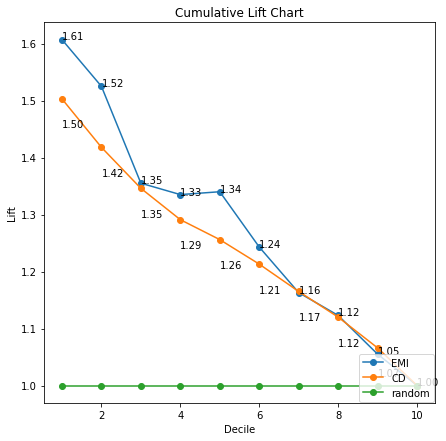

In [55]:
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(1,1,1)



ax1.plot(emi_lift.index,emi_lift["cum_lift"], label = "EMI", marker='o')
for i, txt in enumerate(emi_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (emi_lift.index[i], emi_lift["cum_lift"][i+1]))
    
ax1.plot(cd_lift.index,cd_lift["cum_lift"], label = "CD", marker='o')
for i, txt in enumerate(cd_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (cd_lift.index[i], cd_lift["cum_lift"][i+1]-0.05))



ax1.plot(np.arange(1,11,1),[1,1,1,1,1,1,1,1,1,1], label = 'random', marker='o')

plt.legend(loc='lower right', borderaxespad=0.1)
plt.xlabel("Decile")
plt.ylabel("Lift")

ax1.set_title("Cumulative Lift Chart")
plt.show()    


### Statewise GINI

In [56]:
gini_dic = {}
for x in df_cd["POS_STATE"].unique():
    try:
        if "POS_STATE" not in gini_dic:
            gini_dic["POS_STATE"] = []
        if "EMI" not in gini_dic: 
            gini_dic["EMI"] = []
        if "CD" not in gini_dic: 
            gini_dic["CD"] = []
        
        gini_dic["EMI"].append((2*roc_auc_score(df_emi[df_emi["POS_STATE"]==x][target_variable],df_emi[df_emi["POS_STATE"]==x][risk_score])-1)*100)
        gini_dic["CD"].append((2*roc_auc_score(df_cd[df_cd["POS_STATE"]==x][target_variable],df_cd[df_cd["POS_STATE"]==x][risk_score])-1)*100)
        gini_dic["POS_STATE"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "POS_STATE",inplace = True)
gini_df.reset_index(inplace = True)


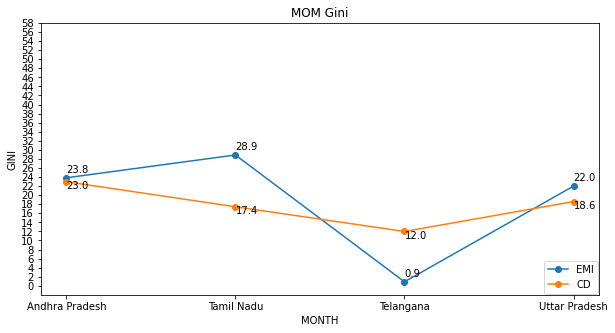

In [57]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["POS_STATE"],gini_df["EMI"], marker='o', scaley = False, label = "EMI")
ax1.plot(gini_df["POS_STATE"],gini_df["CD"], marker='o', scaley = False, label = "CD")
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["EMI"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["POS_STATE"][i], gini_df["EMI"][i]+1.2))
for i, txt in enumerate(gini_df["CD"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["POS_STATE"][i], gini_df["CD"][i]-1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(-2,45)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,60,2))
ax1.set_title("MOM Gini")
plt.show()


In [58]:
df[df["MONTH_STR"]==""].groupby(["PRODUCT_GROUP","POS_STATE"])["RISK_FPD30"].mean()

PRODUCT_GROUP  POS_STATE     
CD             Andhra Pradesh    0.022729
               Tamil Nadu        0.039750
               Telangana         0.038548
               Uttar Pradesh     0.028882
POS=EMI        Andhra Pradesh    0.039924
               Tamil Nadu        0.085873
               Telangana         0.064286
               Uttar Pradesh     0.037938
Name: RISK_FPD30, dtype: float64